In [16]:
import optuna
import yaml
from typing import Any, Dict, Tuple
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder, StandardScaler, OrdinalEncoder, PowerTransformer, RobustScaler, MinMaxScaler,
    FunctionTransformer)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import  accuracy_score, precision_score, recall_score, roc_auc_score, classification_report,f1_score
import numpy as np
from utils_machine_learning import rename_columns_to_snake_case

from custom_transformers import (
    DropRedundantColumns,
    CreateNewFeature,
    LogTransformer,
    OutlierDetector,
    ReplaceValueTransformer,
    OutlierHandler,
)
from optuna.samplers import TPESampler
from sklearn.decomposition import PCA

import joblib
from typing import Union

from imblearn.over_sampling import (
    RandomOverSampler,
    ADASYN,    
)
from imblearn.under_sampling import (
    RandomUnderSampler,
    NearMiss,
)
from imblearn.combine import (
    SMOTEENN,
    SMOTETomek
    )
import copy
pd.set_option('future.no_silent_downcasting', True)

In [3]:
# load the dataset
def load_dataset() -> pd.DataFrame:
    """
    Load the dataset from the CSV file and return it as a pandas DataFrame.

    Args:
        None

    Returns:
        pd.DataFrame: The dataset loaded from the CSV file.
    """
    
    data_path = 'https://github.com/donadviser/datasets/raw/master/data-don/auto_insurance_claim_fraud.csv'
    data = pd.read_csv(data_path, sep=",")
    return (data
            .pipe(rename_columns_to_snake_case)
            #.dropna()
            )

In [4]:
data_raw = load_dataset()
data_raw.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [5]:
data_raw['auto_make'].unique()

array(['Saab', 'Mercedes', 'Dodge', 'Chevrolet', 'Accura', 'Nissan',
       'Audi', 'Toyota', 'Ford', 'Suburu', 'BMW', 'Jeep', 'Honda',
       'Volkswagen'], dtype=object)

In [6]:
onehot_features = ['policy_state', 'collision_type', 'property_damage', 'police_report_available', 
                  'insured_sex', 'insured_education_level', 'insured_relationship', 'incident_type', 
                  'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 
                  'policy_deductable', 'number_of_vehicles_involved', 'bodily_injuries', 'witnesses', 
                  'incident_period_of_day']

numerical_features = ['months_as_customer',  'age', 'policy_annual_premium', 'injury_claim', 
                      'property_claim', 'vehicle_claim', 'vehicle_age',]

ordinal_features = ['insured_hobbies','insured_occupation', 'auto_make' ]

transform_features = ['umbrella_limit', 'capital_gains', 'capital_loss']

drop_columns = ['policy_number','policy_bind_date','policy_csl', 'insured_zip','incident_date',
                'incident_location','auto_model','auto_year', 'incident_hour_of_the_day', 'total_claim_amount'
                ]

bins_hour = [0, 5, 11, 16, 20, 24]  # Time bins for different periods of the day
names_period = ["early_morning", "morning", "afternoon", "evening", "night"] 

target_col = 'fraud_reported'

In [7]:
# Assuming dataset is loaded in a pandas dataframe
X, y = data_raw.drop(columns=[target_col]), data_raw[target_col]

# Splitting the dataset
y = y.map({'Y': 1, 'N': 0})  # Map target labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
# Load YAML configuration file
def load_yaml_config(config_path: str) -> Dict[str, Any]:
    """
    Load the YAML configuration file containing model and hyperparameter definitions.

    Args:
        config_path (str): Path to the YAML configuration file.

    Returns:
        Dict[str, Any]: The loaded configuration as a dictionary.
    """
    with open(config_path, "r") as file:
        return yaml.safe_load(file)

In [8]:
class HyperparameterTuner:
    """
    HyperparameterTuner to return hyperparameters for each classifier.
    """
    def get_params(self, trial: optuna.Trial, classifier_name: str):
        if classifier_name == "RandomForestClassifier":
            return {
                "n_estimators": trial.suggest_int("n_estimators", 50, 300),
                "max_depth": trial.suggest_int("max_depth", 2, 30),
                "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
                "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
            }
        elif classifier_name == "DecisionTreeClassifier":
            return {
                "max_depth": trial.suggest_int("max_depth", 2, 30),
                "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
                "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
            }
        elif classifier_name == "LGBMClassifier":
            return {
                "objective": "binary",
                "metric": "binary_logloss",
                "verbosity": -1,
                "boosting_type": "gbdt",
                "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
                "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
                "num_leaves": trial.suggest_int("num_leaves", 2, 256),
                "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
                "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
                "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
                "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
            }
        elif classifier_name == "XGBClassifier":
            return {
                "verbosity": 0,
                "objective": "binary:logistic",
                "eval_metric": "auc",
                "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
                "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
                "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
                "subsample": trial.suggest_float("subsample", 0.2, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
            }
        elif classifier_name == "CatBoostClassifier":
            return {
                "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
                "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
                "depth": trial.suggest_int("depth", 1, 12),
                "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
                "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
            }
        elif classifier_name == "LogisticRegression":
            # Basic hyperparameters
            params = {
                "solver": trial.suggest_categorical('solver', ['newton-cholesky', 'lbfgs', 'liblinear', 'sag', 'saga']),
                "max_iter": trial.suggest_int('max_iter', 10000, 50000),  # Increased max_iter to allow for better convergence
            }

            # Suggest penalty from a unified set
            all_penalties = ['l1', 'l2', 'elasticnet', None]  # Unified penalties
            params['penalty'] = trial.suggest_categorical('penalty', all_penalties)

            # Only suggest C if penalty is not None
            if params['penalty'] is not None:
                params["C"] = trial.suggest_float('C', 1e-10, 1000, log=True)
            
            # Only suggest l1_ratio if penalty is 'elasticnet'
            if params['penalty'] == 'elasticnet':
                params['l1_ratio'] = trial.suggest_float('l1_ratio', 0, 1)

            # Prune invalid combinations:
            if (
                (params['solver'] == 'lbfgs' and params['penalty'] not in ['l2', None]) or
                (params['solver'] == 'liblinear' and params['penalty'] not in ['l1', 'l2']) or
                (params['solver'] == 'sag' and params['penalty'] not in ['l2', None]) or
                (params['solver'] == 'newton-cholesky' and params['penalty'] not in ['l2', None]) or
                (params['solver'] == 'saga' and params['penalty'] not in ['elasticnet', 'l1', 'l2', None])
            ):
                raise optuna.TrialPruned()  # Invalid combination of solver and penalty

            return params

        
        elif classifier_name == "GradientBoostingClassifier":
            return {
                "learning_rate" : trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
                "n_estimators" : trial.suggest_int('n_estimators', 100, 1000),
                "max_depth" : trial.suggest_int('max_depth', 3, 10),
                "min_samples_split" : trial.suggest_int('min_samples_split', 2, 20),
                "min_samples_leaf" : trial.suggest_int('min_samples_leaf', 1, 20),
                "max_features" : trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    
            }
        elif classifier_name == "KNeighborsClassifier":
            params = {
                "n_neighbors": trial.suggest_int('n_neighbors', 1, 50),
                "weights": trial.suggest_categorical('weights', ['uniform', 'distance']),
                "p": trial.suggest_int('p', 1, 2),  # 1: Manhattan, 2: Euclidean
                "leaf_size": trial.suggest_int('leaf_size', 10, 100),
                "metric": trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski', 'chebyshev'])
            }
            return params
        
        elif classifier_name == "AdaBoostClassifier":
            return {
                "n_estimators": trial.suggest_int('n_estimators', 50, 1000),  # Number of boosting stages
                "learning_rate": trial.suggest_float('learning_rate', 0.01, 1.0, log=True),  # Learning rate for each stage
            }
        else:
            raise ValueError(f"Invalid classifier name: {classifier_name}")

In [9]:
class ModelFactory:
    """
    A class to create model instances with additional parameters for specific classifiers.

    Attributes:
        model_name (str): The name of the model to be instantiated.
        model_hyperparams (dict): The best hyperparameters for the model.
    """

    def __init__(self, model_name: str, model_hyperparams: dict):
        """
        Initialize the ModelFactory with a model name and parameters.
        
        Args:
            model_name (str): The name of the model.
            model_hyperparams (dict): Hyperparameters for the model.
        """
        self.model_name = model_name
        self.model_hyperparams = model_hyperparams

    def get_model_instance(self):
        """
        Creates a model instance based on the model name with additional classifier-specific parameters.

        Returns:
            A model instance with the appropriate parameters.
        """
        # Dictionary of model classes
        model_dict = {
            "LGBMClassifier": LGBMClassifier,
            "XGBClassifier": XGBClassifier,
            "CatBoostClassifier": CatBoostClassifier,
            "RandomForestClassifier": RandomForestClassifier,
            "DecisionTreeClassifier": DecisionTreeClassifier,
            "LogisticRegression": LogisticRegression,
            "SVC": SVC,
            "GradientBoostingClassifier": GradientBoostingClassifier,
            "KNeighborsClassifier": KNeighborsClassifier,
            "AdaBoostClassifier": AdaBoostClassifier
        }

        # Check if the model exists in the model_dict
        if self.model_name not in model_dict:
            raise ValueError(f"Model {self.model_name} is not supported.")

        # Create a model instance with specific parameters
        if self.model_name == "LGBMClassifier":
            return model_dict[self.model_name](**self.model_hyperparams, random_state=42, verbose=-1)  # Add verbose for LGBM
        elif self.model_name == "RandomForestClassifier":
            return model_dict[self.model_name](**self.model_hyperparams, random_state=42, n_jobs=-1)  # Add n_jobs for RandomForest
        elif self.model_name == "SVC":
            return model_dict[self.model_name](**self.model_hyperparams, random_state=42, probability=True)  # Add probability for SVC
        elif self.model_name == "CatBoostClassifier":
            return model_dict[self.model_name](**self.model_hyperparams, random_state=42, verbose=0)  # Suppress CatBoost verbosity
        elif self.model_name == "KNeighborsClassifier":
            return model_dict[self.model_name](**self.model_hyperparams)  # Suppress CatBoost verbosity
        else:
            return model_dict[self.model_name](**self.model_hyperparams, random_state=42)  # Default for other models

In [10]:
class PipelineManager:
    """
    A class that handles both building and modifying pipelines dynamically.
    This class supports both scikit-learn's Pipeline and imbalanced-learn's Pipeline.

    It allows the construction of the initial pipeline and the insertion of steps 
    at any position within the pipeline.
    """

    def __init__(self, pipeline_type='ImbPipeline'):
        """
        Initialize the PipelineManager with a specified pipeline type.

        Args:
            pipeline_type (str): The type of pipeline to use ('ImbPipeline' or 'Pipeline').
        """
        if pipeline_type == 'ImbPipeline':
            self.pipeline = ImbPipeline(steps=[])
        elif pipeline_type == 'Pipeline':
            self.pipeline = Pipeline(steps=[])
        else:
            raise ValueError("Unsupported pipeline type. Choose 'ImbPipeline' or 'Pipeline'.")

    def add_step(self, step_name, step_object, position=None):
        """
        Add a transformation step to the pipeline.

        Args:
            step_name (str): Name of the step to add.
            step_object (object): The transformer or estimator object (e.g., scaler, classifier).
            position (int or None): Optional; the position to insert the step.
                                    If None, the step is appended at the end of the pipeline.
        """
        if position is None:
            self.pipeline.steps.append((step_name, step_object))
        else:
            self.pipeline.steps.insert(position, (step_name, step_object))

    def remove_step(self, step_name):
        """
        Remove a step from the pipeline by its name.

        Args:
            step_name (str): The name of the step to remove.
        """
        self.pipeline.steps = [(name, step) for name, step in self.pipeline.steps if name != step_name]

    def replace_step(self, step_name, new_step_object):
        """
        Replace an existing step in the pipeline with a new step.

        Args:
            step_name (str): The name of the step to replace.
            new_step_object (object): The new transformer or estimator object.
        """
        for i, (name, step) in enumerate(self.pipeline.steps):
            if name == step_name:
                self.pipeline.steps[i] = (step_name, new_step_object)
                break

    def get_pipeline(self):
        """
        Get the constructed or modified pipeline.

        Returns:
            Pipeline: The constructed or modified pipeline object.
        """
        return self.pipeline

In [11]:
class PreprocessingPipeline:
    """
    A class that encapsulates the preprocessing steps for feature engineering,
    imputation, scaling, encoding, and transformations. This can be inserted into
    the overall pipeline before the model fitting step.
    """
    def __init__(self, bins_hour, names_period, drop_columns, numerical_features,
                 onehot_features, ordinal_features, transform_features, trial: optuna.Trial=None):
        """
        Initialize the PreprocessingPipeline with necessary parameters.

        Args:
            bins_hour: Parameters for creating new features from hourly bins.
            names_period: Period names for feature creation.
            drop_columns: Columns to be dropped from the dataset.
            numerical_features: List of numerical features for processing.
            onehot_features: List of categorical features for OneHot encoding.
            ordinal_features: List of ordinal features for Ordinal encoding.
            transform_features: Features that require power transformation.
        """
        self.bins_hour = bins_hour
        self.names_period = names_period
        self.drop_columns = drop_columns
        self.numerical_features = numerical_features
        self.onehot_features = onehot_features
        self.ordinal_features = ordinal_features
        self.transform_features = transform_features
        self.trial = trial
        
    def instantiate_numerical_simple_imputer(self, strategy: str=None, fill_value: int=-1) -> SimpleImputer:
        if strategy is None and self.trial:
            strategy = self.trial.suggest_categorical('numerical_strategy', ['mean', 'median', 'most_frequent'])
        return SimpleImputer(strategy=strategy, fill_value=fill_value)

    def instantiate_categorical_simple_imputer(self, strategy: str=None, fill_value: str='missing') -> SimpleImputer:
        if strategy is None and self.trial:
            strategy = self.trial.suggest_categorical('categorical_strategy', ['most_frequent', 'constant'])
        return SimpleImputer(strategy=strategy, fill_value=fill_value)
    
    def instantiate_outliers(self, strategy: str=None) -> Union[PowerTransformer, FunctionTransformer, OutlierDetector]:
        """
        Instantiate outlier handling method: PowerTransformer, LogTransformer, or OutlierDetector.

        Args:
            trial (optuna.Trial, optional): The trial object for hyperparameter optimization.

        Returns:
            Union[PowerTransformer, FunctionTransformer, OutlierDetector]: The selected outlier handling method.
        """
        # Suggest from available options
        options = ['power_transform', 'log_transform', 'iqr_clip', 'iqr_median', 'iqr_mean']
        if self.trial:
            strategy = self.trial.suggest_categorical('outlier_strategy', options)
        else:
            strategy = strategy  # Default to first option if no trial is provided

        if strategy == 'power_transform':
            return PowerTransformer(method='yeo-johnson')
        elif strategy == 'log_transform':
            return LogTransformer()
            #return FunctionTransformer(np.log1p)  # Log transformation
        elif strategy in ['iqr_clip', 'iqr_median', 'iqr_mean']:
            return OutlierHandler(strategy=strategy)  # Instantiate OutlierDetector
        else:
            raise ValueError(f"Unknown strategy for outlier handling: {strategy}")

         
    def build(self, step_name=None, **column_transformer_strategy):
        """
        Build the preprocessing pipeline with feature creation, transformation, 
        imputation, scaling, and encoding steps.
        
        Returns:
            Transformer: The appropriate transformer for the given step.
        """
        
        if step_name == "create_new_features":
            return CreateNewFeature(bins_hour=self.bins_hour, names_period=self.names_period)
        
        if step_name == "replace_class":
            return ReplaceValueTransformer(old_value="?", new_value=np.nan)
        
        if step_name == "drop_cols":
            return DropRedundantColumns(redundant_cols=self.drop_columns)
        
        if step_name == 'column_transformer':
            
            numerical_strategy = column_transformer_strategy.get('numerical_strategy', None)
            categorical_strategy = column_transformer_strategy.get('categorical_strategy',None)
            outlier_strategy = column_transformer_strategy.get('outlier_strategy', None)        
            
            return ColumnTransformer(
                transformers=[
                    ('cat', Pipeline([
                        ('imputer', self.instantiate_categorical_simple_imputer(strategy=categorical_strategy)),   
                        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
                    ]), self.onehot_features),
                    
                    ('num', Pipeline([
                        ('imputer', self.instantiate_numerical_simple_imputer(strategy=numerical_strategy)),
                        #('scaler', StandardScaler())  # Add scaler if needed
                    ]), self.numerical_features),
                    
                    
                    
                    ('ord', Pipeline([
                        ('imputer', self.instantiate_categorical_simple_imputer(strategy=categorical_strategy)),
                        ('ordinal', OrdinalEncoder())
                    ]), self.ordinal_features),
                    
                    ('out', Pipeline([
                        ('imputer', self.instantiate_numerical_simple_imputer(strategy=numerical_strategy)),
                        ('outlier_transformer', self.instantiate_outliers(strategy=outlier_strategy))  # Update this line
                    ]), self.transform_features),
                ],
                remainder='passthrough'
            )


In [12]:
class ResamplerSelector:
    """
    A class to select and return a resampling algorithm based on a given parameter or 
    from a trial suggestion if available.

    Attributes:
        trial (optuna.trial, optional): The trial object for hyperparameter optimization.
    """

    def __init__(self, trial=None, random_state=42):
        """
        Initialize the ResamplerSelector with an optional trial for hyperparameter optimization.

        Args:
            trial (optuna.trial, optional): An optional trial object for suggesting resampling strategies.
            random_state (int): Random seed for reproducibility. Default is 42.
        """
        self.trial = trial
        self.random_state = random_state

    def get_resampler(self, resampler=None):
        """
        Return the resampling algorithm based on the provided `resampler` parameter.
        If `resampler` is not given, it is suggested from the trial.

        Args:
            resampler (str, optional): The resampling method ('RandomOverSampler', 'ADASYN', etc.). 
                                       If not provided, it will be suggested from the trial (if available).

        Returns:
            resampler_obj (object): The resampling instance based on the selected method.
        """
        if resampler is None and self.trial:
            resampler = self.trial.suggest_categorical(
                'resampler', ['RandomOverSampler', 'ADASYN', 'RandomUnderSampler', 'NearMiss', 'SMOTEENN', 'SMOTETomek']
            )
             

        if resampler == 'RandomOverSampler':
            return RandomOverSampler(random_state=self.random_state)
        elif resampler == 'ADASYN':
            return ADASYN(random_state=self.random_state)
        elif resampler == 'RandomUnderSampler':
            return RandomUnderSampler(random_state=self.random_state)
        elif resampler == 'NearMiss':
            return NearMiss()
        elif resampler == 'SMOTEENN':
            return SMOTEENN(random_state=self.random_state, sampling_strategy='minority' )
        elif resampler == 'SMOTETomek':
            return SMOTETomek(random_state=self.random_state)
        else:
            raise ValueError(f"Unknown resampler: {resampler}")

In [13]:
class ScalerSelector:
    """
    A class to select and return a scaling algorithm based on a given parameter or 
    from a trial suggestion if available.

    Attributes:
        trial (optuna.trial, optional): The trial object for hyperparameter optimization.
    """

    def __init__(self, trial=None):
        """
        Initialize the ScalerSelector with an optional trial for hyperparameter optimization.

        Args:
            trial (optuna.trial, optional): An optional trial object for suggesting resampling strategies.
        """
        self.trial = trial

    def get_scaler(self, scaler_name=None):
        """
        Return the scaling algorithm based on the provided `scaler_name` parameter.
        If `scaler_name` is not given, it is suggested from the trial.

        Args:
            scaler_name (str, optional): The scalring method ('MinMaxScaler', 'StandardScaler', etc.). 
                                       If not provided, it will be suggested from the trial (if available).

        Returns:
            rscaler_obj (object): The scaling instance based on the selected method.
        """ 
         
        # -- Instantiate scaler (skip scaler for CatBoost as it handles categorical features internally)
        if scaler_name is None and self.trial:
            scaler_name = self.trial.suggest_categorical("scaler", ['minmax', 'standard', 'robust'])
            
        if scaler_name == "minmax":
            return MinMaxScaler()
        elif scaler_name == "standard":
            return StandardScaler()
        elif scaler_name == "robust":
            return RobustScaler()
        else:
            raise ValueError(f"Unknown scaler: {scaler_name}")

In [14]:
class DimensionalityReductionSelector:
    """
    A class to select and return a dimensionality reduction algorithm based on a given parameter 
    or from a trial suggestion if available.

    Attributes:
        trial (optuna.trial, optional): The trial object for hyperparameter optimization.
    """

    def __init__(self, trial=None):
        """
        Initialize the DimensionalityReductionSelector with an optional trial for hyperparameter optimization.

        Args:
            trial (optuna.trial, optional): An optional trial object for suggesting dimensionality reduction strategies.
        """
        self.trial = trial

    def get_dimensionality_reduction(self, dim_red=None, pca_n_components=5):
        """
        Return the dimensionality reduction algorithm based on the provided `dim_red` parameter.
        If `dim_red` is not given, it is suggested from the trial.

        Args:
            dim_red (str, optional): The dimensionality reduction method ('PCA' or None). If not provided,
                                     it will be suggested from the trial (if available).

        Returns:
            dimen_red_algorithm (object or str): PCA algorithm or 'passthrough'.
        """
        if dim_red is None and self.trial:
            dim_red = self.trial.suggest_categorical("dim_red", ["PCA", None])

        if dim_red == "PCA":
            if self.trial:
                pca_n_components = self.trial.suggest_int("pca_n_components", 2, 30)
            else:
                pca_n_components = pca_n_components  # Default value if trial is not provided
            dimen_red_algorithm = PCA(n_components=pca_n_components)
        else:
            dimen_red_algorithm = 'passthrough'

        return dimen_red_algorithm


In [15]:
def get_pipeline_model_and_params(classifier_name, trial, model_hyperparams):
    # Got the Preprocessed Pipeline containting Data Cleaning and Column Transformation
    
                    
    preprocessing_pipeline = PreprocessingPipeline(
        bins_hour=bins_hour,
        names_period=names_period,
        drop_columns=drop_columns,
        numerical_features=numerical_features,
        onehot_features=onehot_features,
        ordinal_features=ordinal_features,
        transform_features=transform_features,
        trial=trial
    )


    # Initialize the manager with the preferred pipeline type ('ImbPipeline' or 'Pipeline')
    pipeline_manager = PipelineManager(pipeline_type='ImbPipeline')
    
    pipeline_manager.add_step('create_new_features', preprocessing_pipeline.build(step_name='create_new_features', trial=None), position=0)
    pipeline_manager.add_step('replace_class', preprocessing_pipeline.build(step_name='replace_class', trial=None), position=1)
    pipeline_manager.add_step('drop_cols', preprocessing_pipeline.build(step_name='drop_cols', trial=None), position=2)
    pipeline_manager.add_step('column_transformer', preprocessing_pipeline.build(step_name='column_transformer', trial=trial), position=3)
    
    # Add the resampler step based on the provided resample name or trial suggestion
    resample_selector = ResamplerSelector(trial=trial)   
    resampler_obj = resample_selector.get_resampler()
    pipeline_manager.add_step('resampler', resampler_obj, position=4)
    
    
    # Add the scaler step based on the provided resample name or trial suggestion
    scaler_selector = ScalerSelector(trial=trial)  
    scaler_obj = scaler_selector.get_scaler()
    pipeline_manager.add_step('scaler', scaler_obj, position=5)
    
    
    # Add the Dimensional Reduction step based on the provided parameter or trial suggestion
    dim_red_selector = DimensionalityReductionSelector(trial=trial) 
    dim_red_obj = dim_red_selector.get_dimensionality_reduction()
    #pipeline_manager.add_step('dim_reduction', dim_red_obj, position=6)

    # Create an instance of the ModelFactory class with best_model and best_params
    model_factory = ModelFactory(classifier_name, model_hyperparams)
    model_obj = model_factory.get_model_instance()
    pipeline_manager.add_step('model', model_obj, position=7)
    
    pipeline = pipeline_manager.get_pipeline()
    
    return pipeline



In [16]:
# Define objective function for Optuna
def objective(classifier_name: str, trial: optuna.Trial=None, scoring='f1') -> float:
    """
    Objective function to optimize classifiers dynamically using Optuna.

    Args:
        trial (optuna.Trial): Optuna trial object for suggesting hyperparameters.
        classifier_name (str): Classifier to optimize.
        scoring (str): Scoring metric for cross-validation.

    Returns:
        float: The mean score from cross-validation.
    """
    
    # Get hyperparameters for the classifier from HyperparameterTuner
    hyperparameter_tuner = HyperparameterTuner()
    model_hyperparams = hyperparameter_tuner.get_params(trial, classifier_name)

    
    # Got the Preprocessed Pipeline containting Data Cleaning and Column Transformation
    
    pipeline = get_pipeline_model_and_params(classifier_name=classifier_name, trial=trial, model_hyperparams=model_hyperparams)
    
    # Cross-validation
    kfold = StratifiedKFold(n_splits=10)
    score = cross_val_score(pipeline, X_train, y_train, scoring=scoring, n_jobs=-1, cv=kfold, verbose=0, error_score='raise')
    score_training = score.mean()
    
    #pipeline.fit(X_train, y_train)
    #score_testing = pipeline.score(X_test, y_test)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

        
    tuning_test_metrics = {
    'f1': f1,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'roc_auc': roc_auc,
    'training_score': score_training,

}
    
    return tuning_test_metrics[scoring]

In [17]:
# Define another objective function that shares most of the `objective` function to reproduce the model with the best hyperparameters.

# Define objective function for Optuna
def detailed_objective(classifier_name: str, trial: optuna.Trial=None, scoring='f1') -> Tuple[float, float, float, float, float]:
    """
    Objective function to optimize classifiers dynamically using Optuna.

    Args:
        trial (optuna.Trial): Optuna trial object for suggesting hyperparameters.
        classifier_name (str): Classifier to optimize.
        scoring (str): Scoring metric for cross-validation.

    Returns:
        float: The mean score from cross-validation.
    """
    
    # Get hyperparameters for the classifier from HyperparameterTuner
    hyperparameter_tuner = HyperparameterTuner()
    model_hyperparams = hyperparameter_tuner.get_params(trial, classifier_name)
    #print("hyperparameter parameters obtained from HyperparameterTuner class")
    
    # Got the Preprocessed Pipeline containting Data Cleaning and Column Transformation
    
    pipeline = get_pipeline_model_and_params(classifier_name, trial, model_hyperparams=model_hyperparams)
    
    # Cross-validation
    kfold = StratifiedKFold(n_splits=10)
    score = cross_val_score(pipeline, X_train, y_train, scoring=scoring, n_jobs=-1, cv=kfold, verbose=0, error_score='raise')
    score_training = score.mean()
    
    
     
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    metrics_test = {
        'classifier_name': classifier_name,
        'f1': f1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc,
        f'score_training_{scoring}': score_training,
        'best_params': trial,
        "classification_report": classification_report(y_test, y_pred, output_dict=True)  # Detailed report
        }
    
    # Save the variables to a file
    # Serialise the trained pipeline
    joblib.dump((pipeline, metrics_test), f'{classifier_name}_pipeline.pkl')
    print(f'Serialized {classifier_name} pipeline and test metrics to {classifier_name}_pipeline.pkl')
    
     

    return metrics_test
    

In [18]:
# Run the Optuna study
def run_optimization(config_path: str, n_trials: int = 100, scoring: str = 'f1') -> None:
    """
    Run Optuna study for hyperparameter tuning and model selection.
    
    Args:
        config_path (str): Path to the YAML configuration file.
        n_trials (int): Number of trials for optimization. Defaults to 100.
        scoring (str): Scoring metric for optimization. Defaults to 'f1'.
    """
    
    best_model_score = 0
    best_model = None
    best_params = None
    best_of_models = []
    scores_dict = {}

    all_models = ["RandomForestClassifier", "DecisionTreeClassifier", 
                  "XGBClassifier", "LGBMClassifier", "GradientBoostingClassifier", 
                  "LogisticRegression", "KNeighborsClassifier", "CatBoostClassifier", "AdaBoostClassifier"]
    
    #all_models = ["DecisionTreeClassifier", "RandomForestClassifier", "LogisticRegression", "XGBClassifier", 'KNeighborsClassifier']

    for classifier_name in all_models:
        print(f"Optimizing model: {classifier_name} | Scoring: {scoring}")
        study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=11))
        study.optimize(lambda trial: objective(classifier_name, trial, scoring), n_trials=n_trials)
        
        print(f"classifier_name: {classifier_name} | study.best_trial.value: {study.best_trial.value}")

        best_trial = study.best_trial
        best_of_models.append({
            "model": classifier_name,
            "model_score_params": best_trial.params,
            "model_score_trial_number": best_trial.number,
            "model_score_datetime": best_trial.datetime_start,
            "model_score_duration": best_trial.duration,
            "model_score_status": best_trial.state,
            "model_score_key": scoring,
            "model_score_value": best_trial.value
            
        })

        current_score = best_trial.value
        
        
        if current_score and current_score > best_model_score:
            best_model_score = best_trial.value
            best_model = classifier_name
            best_params = best_trial.params
            
        print(f"Current Model: {classifier_name}, Current Score: {current_score} | Best Model: {best_model}, Best Score: {best_model_score}")
            
        best_parameters_results = detailed_objective(classifier_name=classifier_name, trial=study.best_trial,  scoring=scoring)
        print(f"Best Parameters: {best_parameters_results}")
        

    # Display all results and the best model
    for result in best_of_models:
        print(result)
    
    print("Best model:", best_model)
    print("Best parameters:", best_params)
    
    
    # Save the variables to a file
    with open("best_model_and_params.pkl", "wb") as f:
        joblib.dump((best_model, best_params), f)
    

   
    
    return best_model, best_params, current_score

In [19]:
if __name__ == "__main__":
    config_path = "model_config.yaml"
    best_model, best_params, current_score = run_optimization(config_path, n_trials=30, scoring='f1')
    

[I 2024-11-09 17:40:24,256] A new study created in memory with name: no-name-bb74cf23-76f5-45fa-ae89-a5f1286a91a4


Optimizing model: RandomForestClassifier | Scoring: f1


[I 2024-11-09 17:40:27,409] Trial 0 finished with value: 0.5565217391304348 and parameters: {'n_estimators': 95, 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 15, 'categorical_strategy': 'constant', 'numerical_strategy': 'most_frequent', 'outlier_strategy': 'iqr_median', 'resampler': 'ADASYN', 'scaler': 'standard', 'dim_red': 'PCA', 'pca_n_components': 4}. Best is trial 0 with value: 0.5565217391304348.
[I 2024-11-09 17:40:28,275] Trial 1 finished with value: 0.4225352112676056 and parameters: {'n_estimators': 228, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 10, 'categorical_strategy': 'constant', 'numerical_strategy': 'mean', 'outlier_strategy': 'log_transform', 'resampler': 'ADASYN', 'scaler': 'standard', 'dim_red': None}. Best is trial 0 with value: 0.5565217391304348.
[I 2024-11-09 17:40:28,709] Trial 2 finished with value: 0.6021505376344086 and parameters: {'n_estimators': 140, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 15, 'categ

classifier_name: RandomForestClassifier | study.best_trial.value: 0.6476190476190476
Current Model: RandomForestClassifier, Current Score: 0.6476190476190476 | Best Model: RandomForestClassifier, Best Score: 0.6476190476190476


[I 2024-11-09 17:40:48,553] A new study created in memory with name: no-name-7c8ebd21-b4dd-4aa1-93bf-65170ed784e1
[I 2024-11-09 17:40:48,682] Trial 0 finished with value: 0.631578947368421 and parameters: {'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 10, 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'most_frequent', 'outlier_strategy': 'power_transform', 'resampler': 'RandomOverSampler', 'scaler': 'robust', 'dim_red': 'PCA', 'pca_n_components': 5}. Best is trial 0 with value: 0.631578947368421.


Serialized RandomForestClassifier pipeline and test metrics to RandomForestClassifier_pipeline.pkl
Best Parameters: {'classifier_name': 'RandomForestClassifier', 'f1': 0.6476190476190476, 'accuracy': 0.815, 'precision': 0.6071428571428571, 'recall': 0.6938775510204082, 'roc_auc': 0.7925395323692391, 'score_training_f1': 0.579366710375666, 'best_params': FrozenTrial(number=29, state=1, values=[0.6476190476190476], datetime_start=datetime.datetime(2024, 11, 9, 17, 40, 47, 91492), datetime_complete=datetime.datetime(2024, 11, 9, 17, 40, 47, 792218), params={'n_estimators': 253, 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 12, 'categorical_strategy': 'constant', 'numerical_strategy': 'most_frequent', 'outlier_strategy': 'iqr_median', 'resampler': 'SMOTETomek', 'scaler': 'robust', 'dim_red': 'PCA', 'pca_n_components': 6}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=300, log=False, low=50, step=1), 'max_depth': I

[I 2024-11-09 17:40:48,826] Trial 1 finished with value: 0.7304347826086957 and parameters: {'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 12, 'categorical_strategy': 'constant', 'numerical_strategy': 'median', 'outlier_strategy': 'iqr_median', 'resampler': 'ADASYN', 'scaler': 'robust', 'dim_red': 'PCA', 'pca_n_components': 18}. Best is trial 1 with value: 0.7304347826086957.
[I 2024-11-09 17:40:48,963] Trial 2 finished with value: 0.5777777777777777 and parameters: {'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 4, 'categorical_strategy': 'constant', 'numerical_strategy': 'most_frequent', 'outlier_strategy': 'iqr_median', 'resampler': 'SMOTEENN', 'scaler': 'minmax', 'dim_red': 'PCA', 'pca_n_components': 19}. Best is trial 1 with value: 0.7304347826086957.
[I 2024-11-09 17:40:49,098] Trial 3 finished with value: 0.6213592233009708 and parameters: {'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 2, 'categorical_strategy': 'constant', 'numerical

classifier_name: DecisionTreeClassifier | study.best_trial.value: 0.7304347826086957
Current Model: DecisionTreeClassifier, Current Score: 0.7304347826086957 | Best Model: DecisionTreeClassifier, Best Score: 0.7304347826086957
Serialized DecisionTreeClassifier pipeline and test metrics to DecisionTreeClassifier_pipeline.pkl
Best Parameters: {'classifier_name': 'DecisionTreeClassifier', 'f1': 0.7304347826086957, 'accuracy': 0.845, 'precision': 0.6363636363636364, 'recall': 0.8571428571428571, 'roc_auc': 0.8388295715637248, 'score_training_f1': 0.7262580047598219, 'best_params': FrozenTrial(number=1, state=1, values=[0.7304347826086957], datetime_start=datetime.datetime(2024, 11, 9, 17, 40, 48, 683166), datetime_complete=datetime.datetime(2024, 11, 9, 17, 40, 48, 826133), params={'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 12, 'categorical_strategy': 'constant', 'numerical_strategy': 'median', 'outlier_strategy': 'iqr_median', 'resampler': 'ADASYN', 'scaler': 'robust', '

[I 2024-11-09 17:40:54,850] Trial 0 finished with value: 0.5617977528089888 and parameters: {'booster': 'dart', 'lambda': 0.0063018989280880545, 'alpha': 2.299475764751072e-05, 'subsample': 0.5883416785342259, 'colsample_bytree': 0.21022465167248694, 'categorical_strategy': 'constant', 'numerical_strategy': 'mean', 'outlier_strategy': 'power_transform', 'resampler': 'SMOTEENN', 'scaler': 'minmax', 'dim_red': 'PCA', 'pca_n_components': 3}. Best is trial 0 with value: 0.5617977528089888.
[I 2024-11-09 17:40:59,133] Trial 1 finished with value: 0.5333333333333333 and parameters: {'booster': 'dart', 'lambda': 0.005530869795959275, 'alpha': 0.0006554090139173701, 'subsample': 0.6419070572043979, 'colsample_bytree': 0.95928191819731, 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'median', 'outlier_strategy': 'power_transform', 'resampler': 'ADASYN', 'scaler': 'robust', 'dim_red': 'PCA', 'pca_n_components': 24}. Best is trial 0 with value: 0.5617977528089888.
[I 2024-11-09 17

classifier_name: XGBClassifier | study.best_trial.value: 0.6379310344827587
Current Model: XGBClassifier, Current Score: 0.6379310344827587 | Best Model: DecisionTreeClassifier, Best Score: 0.7304347826086957


[I 2024-11-09 17:41:16,826] A new study created in memory with name: no-name-5983b9d9-c202-4299-aed5-18da4f6489bc


Serialized XGBClassifier pipeline and test metrics to XGBClassifier_pipeline.pkl
Best Parameters: {'classifier_name': 'XGBClassifier', 'f1': 0.6379310344827587, 'accuracy': 0.79, 'precision': 0.5522388059701493, 'recall': 0.7551020408163265, 'roc_auc': 0.8022705771050141, 'score_training_f1': 0.5548443647367985, 'best_params': FrozenTrial(number=26, state=1, values=[0.6379310344827587], datetime_start=datetime.datetime(2024, 11, 9, 17, 41, 15, 797039), datetime_complete=datetime.datetime(2024, 11, 9, 17, 41, 16, 18871), params={'booster': 'gblinear', 'lambda': 0.0075323413967032845, 'alpha': 5.5265379341442664e-05, 'subsample': 0.8651517787397635, 'colsample_bytree': 0.20091184080798025, 'categorical_strategy': 'constant', 'numerical_strategy': 'most_frequent', 'outlier_strategy': 'iqr_clip', 'resampler': 'ADASYN', 'scaler': 'standard', 'dim_red': None}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'booster': CategoricalDistribution(choices=('gbtree', 'gblinea

[I 2024-11-09 17:41:24,378] Trial 0 finished with value: 0.5454545454545454 and parameters: {'lambda_l1': 4.192057199912162e-07, 'lambda_l2': 1.4971908813890094e-08, 'num_leaves': 120, 'feature_fraction': 0.8349603575152886, 'bagging_fraction': 0.6521221627526365, 'bagging_freq': 4, 'min_child_samples': 6, 'categorical_strategy': 'constant', 'numerical_strategy': 'mean', 'outlier_strategy': 'power_transform', 'resampler': 'SMOTEENN', 'scaler': 'minmax', 'dim_red': 'PCA', 'pca_n_components': 3}. Best is trial 0 with value: 0.5454545454545454.
[I 2024-11-09 17:41:25,860] Trial 1 finished with value: 0.4523809523809524 and parameters: {'lambda_l1': 0.00020805374373855748, 'lambda_l2': 4.1218133893619944e-05, 'num_leaves': 218, 'feature_fraction': 0.8307095076039273, 'bagging_fraction': 0.7612384307492948, 'bagging_freq': 4, 'min_child_samples': 96, 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'median', 'outlier_strategy': 'power_transform', 'resampler': 'ADASYN', 'scaler

classifier_name: LGBMClassifier | study.best_trial.value: 0.7058823529411765
Current Model: LGBMClassifier, Current Score: 0.7058823529411765 | Best Model: DecisionTreeClassifier, Best Score: 0.7304347826086957


[I 2024-11-09 17:41:59,690] A new study created in memory with name: no-name-c0017a39-757f-4058-9afc-205e41e7e2ee


Serialized LGBMClassifier pipeline and test metrics to LGBMClassifier_pipeline.pkl
Best Parameters: {'classifier_name': 'LGBMClassifier', 'f1': 0.7058823529411765, 'accuracy': 0.825, 'precision': 0.6, 'recall': 0.8571428571428571, 'roc_auc': 0.8020002703067982, 'score_training_f1': 0.6350158145496149, 'best_params': FrozenTrial(number=26, state=1, values=[0.7058823529411765], datetime_start=datetime.datetime(2024, 11, 9, 17, 41, 52, 829070), datetime_complete=datetime.datetime(2024, 11, 9, 17, 41, 53, 711647), params={'lambda_l1': 0.0694030209044469, 'lambda_l2': 0.000409043722771794, 'num_leaves': 201, 'feature_fraction': 0.47205452208607546, 'bagging_fraction': 0.8851805637401957, 'bagging_freq': 6, 'min_child_samples': 69, 'categorical_strategy': 'constant', 'numerical_strategy': 'mean', 'outlier_strategy': 'log_transform', 'resampler': 'RandomUnderSampler', 'scaler': 'robust', 'dim_red': None}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lambda_l1': Floa

[I 2024-11-09 17:42:00,405] Trial 0 finished with value: 0.5797101449275363 and parameters: {'learning_rate': 0.002796081833841858, 'n_estimators': 117, 'max_depth': 6, 'min_samples_split': 15, 'min_samples_leaf': 9, 'max_features': None, 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'most_frequent', 'outlier_strategy': 'power_transform', 'resampler': 'NearMiss', 'scaler': 'robust', 'dim_red': 'PCA', 'pca_n_components': 15}. Best is trial 0 with value: 0.5797101449275363.
[I 2024-11-09 17:42:04,106] Trial 1 finished with value: 0.5116279069767442 and parameters: {'learning_rate': 0.009885561623135837, 'n_estimators': 864, 'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 12, 'max_features': 'log2', 'categorical_strategy': 'constant', 'numerical_strategy': 'median', 'outlier_strategy': 'iqr_mean', 'resampler': 'RandomOverSampler', 'scaler': 'minmax', 'dim_red': 'PCA', 'pca_n_components': 22}. Best is trial 0 with value: 0.5797101449275363.
[I 2024-11-09 17:42

classifier_name: GradientBoostingClassifier | study.best_trial.value: 0.7321428571428571
Current Model: GradientBoostingClassifier, Current Score: 0.7321428571428571 | Best Model: GradientBoostingClassifier, Best Score: 0.7321428571428571


[I 2024-11-09 17:44:00,152] A new study created in memory with name: no-name-b55b2d49-e60a-4b32-9362-8e8da1f16933
[I 2024-11-09 17:44:00,153] Trial 0 pruned. 


Serialized GradientBoostingClassifier pipeline and test metrics to GradientBoostingClassifier_pipeline.pkl
Best Parameters: {'classifier_name': 'GradientBoostingClassifier', 'f1': 0.7321428571428571, 'accuracy': 0.85, 'precision': 0.6507936507936508, 'recall': 0.8367346938775511, 'roc_auc': 0.8453845114204621, 'score_training_f1': 0.6880680634300489, 'best_params': FrozenTrial(number=24, state=1, values=[0.7321428571428571], datetime_start=datetime.datetime(2024, 11, 9, 17, 43, 35, 737605), datetime_complete=datetime.datetime(2024, 11, 9, 17, 43, 41, 821015), params={'learning_rate': 0.0017767484951591043, 'n_estimators': 562, 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': None, 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'mean', 'outlier_strategy': 'iqr_mean', 'resampler': 'SMOTETomek', 'scaler': 'standard', 'dim_red': 'PCA', 'pca_n_components': 10}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rat

/Users/donadviser/.pyenv/versions/3.11.10/envs/venv311_insure/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:497: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=4.27843e-17): result may not be accurate.
  warnings.warn(
/Users/donadviser/.pyenv/versions/3.11.10/envs/venv311_insure/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:497: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid su

classifier_name: LogisticRegression | study.best_trial.value: 0.6554621848739496
Current Model: LogisticRegression, Current Score: 0.6554621848739496 | Best Model: GradientBoostingClassifier, Best Score: 0.7321428571428571
Serialized LogisticRegression pipeline and test metrics to LogisticRegression_pipeline.pkl
Best Parameters: {'classifier_name': 'LogisticRegression', 'f1': 0.6554621848739496, 'accuracy': 0.795, 'precision': 0.5571428571428572, 'recall': 0.7959183673469388, 'roc_auc': 0.8084876334639817, 'score_training_f1': 0.5709925179851469, 'best_params': FrozenTrial(number=24, state=1, values=[0.6554621848739496], datetime_start=datetime.datetime(2024, 11, 9, 17, 44, 20, 242069), datetime_complete=datetime.datetime(2024, 11, 9, 17, 44, 20, 508739), params={'solver': 'liblinear', 'max_iter': 49121, 'penalty': 'l2', 'C': 5.75769619635867, 'categorical_strategy': 'constant', 'numerical_strategy': 'median', 'outlier_strategy': 'iqr_median', 'resampler': 'ADASYN', 'scaler': 'minmax',

[I 2024-11-09 17:44:32,226] Trial 0 finished with value: 0.04 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 2, 'leaf_size': 48, 'metric': 'chebyshev', 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'median', 'outlier_strategy': 'log_transform', 'resampler': 'RandomUnderSampler', 'scaler': 'standard', 'dim_red': None}. Best is trial 0 with value: 0.04.
[I 2024-11-09 17:44:32,429] Trial 1 finished with value: 0.4576271186440678 and parameters: {'n_neighbors': 21, 'weights': 'uniform', 'p': 2, 'leaf_size': 60, 'metric': 'manhattan', 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'mean', 'outlier_strategy': 'iqr_median', 'resampler': 'SMOTETomek', 'scaler': 'robust', 'dim_red': None}. Best is trial 1 with value: 0.4576271186440678.
[I 2024-11-09 17:44:32,573] Trial 2 finished with value: 0.4857142857142857 and parameters: {'n_neighbors': 37, 'weights': 'uniform', 'p': 1, 'leaf_size': 83, 'metric': 'minkowski', 'categorical_strategy': 'most_

classifier_name: KNeighborsClassifier | study.best_trial.value: 0.48695652173913045
Current Model: KNeighborsClassifier, Current Score: 0.48695652173913045 | Best Model: GradientBoostingClassifier, Best Score: 0.7321428571428571
Serialized KNeighborsClassifier pipeline and test metrics to KNeighborsClassifier_pipeline.pkl
Best Parameters: {'classifier_name': 'KNeighborsClassifier', 'f1': 0.48695652173913045, 'accuracy': 0.705, 'precision': 0.42424242424242425, 'recall': 0.5714285714285714, 'roc_auc': 0.6873226111636709, 'score_training_f1': 0.38477365748140907, 'best_params': FrozenTrial(number=22, state=1, values=[0.48695652173913045], datetime_start=datetime.datetime(2024, 11, 9, 17, 44, 35, 407223), datetime_complete=datetime.datetime(2024, 11, 9, 17, 44, 35, 574354), params={'n_neighbors': 28, 'weights': 'uniform', 'p': 1, 'leaf_size': 75, 'metric': 'minkowski', 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'median', 'outlier_strategy': 'iqr_median', 'resampler': '

[I 2024-11-09 17:44:45,401] Trial 0 finished with value: 0.578125 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.05168966738485102, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'median', 'outlier_strategy': 'log_transform', 'resampler': 'RandomUnderSampler', 'scaler': 'standard', 'dim_red': None}. Best is trial 0 with value: 0.578125.
[I 2024-11-09 17:44:51,247] Trial 1 finished with value: 0.46153846153846156 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.0746064261405891, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'mean', 'outlier_strategy': 'iqr_median', 'resampler': 'SMOTETomek', 'scaler': 'robust', 'dim_red': None}. Best is trial 0 with value: 0.578125.
[I 2024-11-09 17:44:58,151] Trial 2 finished with value: 0.5806451612903226 and parameters: {'objective': 'CrossEntropy', 'co

classifier_name: CatBoostClassifier | study.best_trial.value: 0.6481481481481481
Current Model: CatBoostClassifier, Current Score: 0.6481481481481481 | Best Model: GradientBoostingClassifier, Best Score: 0.7321428571428571


[I 2024-11-09 17:56:54,315] A new study created in memory with name: no-name-c0661904-1673-4975-81d6-49015619bb5a


Serialized CatBoostClassifier pipeline and test metrics to CatBoostClassifier_pipeline.pkl
Best Parameters: {'classifier_name': 'CatBoostClassifier', 'f1': 0.6481481481481481, 'accuracy': 0.81, 'precision': 0.5932203389830508, 'recall': 0.7142857142857143, 'roc_auc': 0.8129476956345453, 'score_training_f1': 0.6685893630112199, 'best_params': FrozenTrial(number=25, state=1, values=[0.6481481481481481], datetime_start=datetime.datetime(2024, 11, 9, 17, 56, 8, 887745), datetime_complete=datetime.datetime(2024, 11, 9, 17, 56, 15, 865721), params={'objective': 'Logloss', 'colsample_bylevel': 0.08178324742527486, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'categorical_strategy': 'most_frequent', 'numerical_strategy': 'mean', 'outlier_strategy': 'iqr_clip', 'resampler': 'RandomOverSampler', 'scaler': 'minmax', 'dim_red': 'PCA', 'pca_n_components': 7}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'objective': CategoricalDistribution(choices

/Users/donadviser/.pyenv/versions/3.11.10/envs/venv311_insure/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/donadviser/.pyenv/versions/3.11.10/envs/venv311_insure/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/donadviser/.pyenv/versions/3.11.10/envs/venv311_insure/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/donadviser/.pyenv/versions/3.11.10/envs/venv311_insure/lib/python3.11/site-packages/sklearn/ensemble/_weight

classifier_name: AdaBoostClassifier | study.best_trial.value: 0.7304347826086957
Current Model: AdaBoostClassifier, Current Score: 0.7304347826086957 | Best Model: GradientBoostingClassifier, Best Score: 0.7321428571428571


/Users/donadviser/.pyenv/versions/3.11.10/envs/venv311_insure/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Serialized AdaBoostClassifier pipeline and test metrics to AdaBoostClassifier_pipeline.pkl
Best Parameters: {'classifier_name': 'AdaBoostClassifier', 'f1': 0.7304347826086957, 'accuracy': 0.845, 'precision': 0.6363636363636364, 'recall': 0.8571428571428571, 'roc_auc': 0.8101094742532774, 'score_training_f1': 0.7480592775041717, 'best_params': FrozenTrial(number=29, state=1, values=[0.7304347826086957], datetime_start=datetime.datetime(2024, 11, 9, 17, 57, 56, 216176), datetime_complete=datetime.datetime(2024, 11, 9, 17, 57, 59, 864314), params={'n_estimators': 985, 'learning_rate': 0.013648070648487786, 'categorical_strategy': 'constant', 'numerical_strategy': 'most_frequent', 'outlier_strategy': 'log_transform', 'resampler': 'RandomOverSampler', 'scaler': 'robust', 'dim_red': 'PCA', 'pca_n_components': 8}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=50, step=1), 'learning_rate': FloatDistribution(high

In [9]:
# Function to deserialise a pipeline for inference
def load_pipeline(model_name):
    return joblib.load(f'{model_name}_pipeline.pkl')

In [11]:
# Load the serialized model and metrics test results
model_name = "KNeighborsClassifier"
pipeline, metrics_test = load_pipeline(model_name)
# Perform predictions
#predictions = pipeline.predict(new_data)
#print(pipeline[2:4])

In [22]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba) #Calculate Roc

test_results = {
    'f1_score': f1,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'roc_auc': roc_auc,
    'model_name': model_name,
    'best_params': best_params,
}

In [12]:
# Assume `pipeline` is your final fitted pipeline
# Also, assume `X_train` is your training DataFrame

# Fit the pipeline (if not already fitted)
#pipeline.fit(X_train)

# If you have a ColumnTransformer, find it in the pipeline
column_transformer = None
for name, step in pipeline.named_steps.items():
    if isinstance(step, ColumnTransformer):
        column_transformer = step
        break

# If you have a ColumnTransformer, get the feature names
if column_transformer is not None:
    # Get transformed column names
    feature_names = []
    for name, transformer, columns in column_transformer.transformers_:
        if transformer != 'drop':
            if hasattr(transformer, 'get_feature_names_out'):
                feature_names.extend(transformer.get_feature_names_out(columns))
            else:
                # If the transformer does not have get_feature_names_out method
                feature_names.extend(columns)
else:
    # No ColumnTransformer, fallback to input features
    feature_names = X_train.columns.tolist()

print("Extracted Feature Names: ", feature_names)

Extracted Feature Names:  ['policy_state_IN', 'policy_state_OH', 'collision_type_Rear Collision', 'collision_type_Side Collision', 'property_damage_YES', 'police_report_available_YES', 'insured_sex_MALE', 'insured_education_level_College', 'insured_education_level_High School', 'insured_education_level_JD', 'insured_education_level_MD', 'insured_education_level_Masters', 'insured_education_level_PhD', 'insured_relationship_not-in-family', 'insured_relationship_other-relative', 'insured_relationship_own-child', 'insured_relationship_unmarried', 'insured_relationship_wife', 'incident_type_Parked Car', 'incident_type_Single Vehicle Collision', 'incident_type_Vehicle Theft', 'incident_severity_Minor Damage', 'incident_severity_Total Loss', 'incident_severity_Trivial Damage', 'authorities_contacted_Fire', 'authorities_contacted_Other', 'authorities_contacted_Police', 'incident_state_NY', 'incident_state_OH', 'incident_state_PA', 'incident_state_SC', 'incident_state_VA', 'incident_state_WV',

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

# Assume `pipeline` is your final fitted pipeline
# Also, assume `X_train` is your training DataFrame

# Fit the pipeline (if not already fitted)
#pipeline.fit(X_train)

# Initialize variables to store feature names
column_transformer = None
pca_step_name = None
pca_n_components = None

# Identify if there's a ColumnTransformer in the pipeline
for name, step in pipeline.named_steps.items():
    if isinstance(step, ColumnTransformer):
        column_transformer = step
        break

# Identify if there's PCA in the pipeline
for name, step in pipeline.named_steps.items():
    if hasattr(step, 'named_steps') and 'pca' in step.named_steps:
        pca_step_name = 'pca'
        pca_n_components = step.named_steps['pca'].n_components_
        break
    elif isinstance(step, PCA):
        pca_step_name = name
        pca_n_components = step.n_components_
        break

# If you have a ColumnTransformer, get the feature names
if column_transformer is not None:
    feature_names = []
    for name, transformer, columns in column_transformer.transformers_:
        if transformer != 'drop':
            if hasattr(transformer, 'get_feature_names_out'):
                feature_names.extend(transformer.get_feature_names_out(columns))
            else:
                # If the transformer does not have get_feature_names_out method
                feature_names.extend(columns)
else:
    # No ColumnTransformer, fallback to input features
    feature_names = X_train.columns.tolist()

# Handle PCA Case
if pca_step_name is not None:
    # Replace original feature names with PCA component names
    feature_names = [f"PC{i+1}" for i in range(pca_n_components)]

print("Extracted Feature Names: ", feature_names)


Extracted Feature Names:  ['policy_state_IN', 'policy_state_OH', 'collision_type_Rear Collision', 'collision_type_Side Collision', 'property_damage_YES', 'police_report_available_YES', 'insured_sex_MALE', 'insured_education_level_College', 'insured_education_level_High School', 'insured_education_level_JD', 'insured_education_level_MD', 'insured_education_level_Masters', 'insured_education_level_PhD', 'insured_relationship_not-in-family', 'insured_relationship_other-relative', 'insured_relationship_own-child', 'insured_relationship_unmarried', 'insured_relationship_wife', 'incident_type_Parked Car', 'incident_type_Single Vehicle Collision', 'incident_type_Vehicle Theft', 'incident_severity_Minor Damage', 'incident_severity_Total Loss', 'incident_severity_Trivial Damage', 'authorities_contacted_Fire', 'authorities_contacted_Other', 'authorities_contacted_Police', 'incident_state_NY', 'incident_state_OH', 'incident_state_PA', 'incident_state_SC', 'incident_state_VA', 'incident_state_WV',

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

def display_feature_importance(model, X, y, feature_names, n_top=10):
    """
    This function takes in a dictionary of models, the dataset X, y, and the feature names.
    It fits each model, extracts feature importances (if available), 
    and plots the top n features.

    Parameters:
    models (dict): A dictionary containing model names and their respective model objects.
    X (np.ndarray): Feature dataset.
    y (pd.Series): Target variable.
    feature_names (list): List of feature names after transformations.
    n_top (int): Number of top features to display. Default is 10.
    
    Returns:
    None
    """
    model_name = 'classifier'
     
    # Fit the model
    #model.fit(X, y)
    print(f"Feature ranking for model: {model_name}")
    try:
        # Check if the model has the attribute `feature_importances_`
        if hasattr(model, 'feature_importances_'):
            # Get feature importances
            importance_scores = model.feature_importances_
            
        else:                 
            print(f"{model_name} does not support feature importances.")
            importance_scores = model.coef_[0]
            
        # Create a DataFrame from feature names and importances
        data = {'Feature': feature_names, 'Score': importance_scores}
        df = pd.DataFrame(data)
        
        
        # Take the absolute value of the score
        df['Abs_Score'] = np.abs(df['Score'])
        
        df_sorted = df.sort_values(by="Abs_Score", ascending=False)
        if n_top:
            # Sort by absolute value of score in descending order (top 10)
            df_sorted = df_sorted.head(n_top)
        
        # Define a color palette based on score values (positive = green, negative = red)
        colors = ["green" if score > 0 else "red" for score in df_sorted["Score"]]
        plt.figure(figsize=(12, 8))
        # Create the bar chart with Seaborn
        sns.barplot(x="Feature", y="Score", hue="Feature", legend=False, data=df_sorted, palette=colors)
        
        # Customize the plot for better visual appeal
        plt.xlabel("Feature")
        plt.ylabel("Feature Importance Score")
        plt.title(f"Feature Importance in {model_name} Classification")
        plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
        plt.tight_layout()  # Adjust spacing between elements
    
        # Display the plot
        plt.show()
                
        
            
    except Exception as e:
        print(f"Error occurred while extracting feature importances: {str(e)}")

In [26]:
fitted_model = pipeline.named_steps['model']
fitted_model

KNeighborsClassifier(leaf_size=75, n_neighbors=28, p=1)

In [27]:
# Call the display feature importance function after model evaluation
display_feature_importance(fitted_model, X_train, y_train, feature_names, n_top=10)  # Specify how many top features to display

Feature ranking for model: classifier
classifier does not support feature importances.
Error occurred while extracting feature importances: 'KNeighborsClassifier' object has no attribute 'coef_'


In [28]:
#from shap_visualization_logger import SHAPLogger


In [ ]:
import copy
import shap
import os
class SHAPLogger:
    def __init__(self, pipeline: Pipeline, X_test: pd.DataFrame, model_name:str="model", artefact_dir_path: str=""):
        # Store model, data, and name
        self.pipeline = pipeline
        self.X_test = X_test
        self.model_name = model_name
        self.artefact_dir_path = artefact_dir_path
        
        self.tree_based_classifiers = [
            'RandomForestClassifier',
            'GradientBoostingClassifier',
            'ExtraTreesClassifier',
            'DecisionTreeClassifier',
            'HistGradientBoostingClassifier',
            'AdaBoostClassifier',             
        ]
        
        self.non_sklearn_classifiers = [
            "XGBClassifier",                # xgboost
            "LGBMClassifier",               # lightgbm
            "CatBoostClassifier",           # catboost
            "LogisticRegression",
        ]        
        
        # Prepare the preprocessor and transform data
        self._prepare_data()

    def _prepare_data(self):
        # Deep copy the pipeline to separate the preprocessor from the model
        preprocessor = copy.deepcopy(self.pipeline)
        preprocessor.steps = [(name, step) for name, step in preprocessor.steps if name != 'model']
        
        # Transform X_test using the preprocessor and retrieve transformed feature names
        self.X_test_transformed = preprocessor.transform(self.X_test)
        
        if isinstance(preprocessor.named_steps['column_transformer'], ColumnTransformer):
            self.feature_names = preprocessor.named_steps['column_transformer'].get_feature_names_out()
        else:
            self.feature_names = self.X_test.columns  # Use original names if no transformation
        
        # Confirm shape match with SHAP
        if self.X_test_transformed.shape[1] != len(self.feature_names):
            raise ValueError(f"Mismatch: {self.X_test_transformed.shape[1]} transformed features vs {len(self.feature_names)} feature names.")
        
        # Convert transformed data to DataFrame for SHAP with feature names
        self.X_test_transformed_df = pd.DataFrame(self.X_test_transformed, columns=self.feature_names)
        
        # Extract the final model from the pipeline
        self.model = self.pipeline.named_steps['model']
        
        # Set up SHAP explainer for Tree-based model
        if self.model_name  in self.non_sklearn_classifiers:
            ## Initialize SHAP Explainer
            self.explainer = shap.Explainer(self.model, self.X_test_transformed_df)
            self.shap_values = self.explainer(self.X_test_transformed_df)
            # SHAP Summary plot (this part remains the same)
            shap.summary_plot(self.shap_values, self.X_test_transformed_df, show=False)
        elif self.model_name  == 'KNeighborsClassifier':
            # Get the model explainer object
            #self.explainer = shap.KernelExplainer(self.model.predict_proba, self.X_test_transformed_df)
            self.explainer = shap.KernelExplainer(self.model.predict_proba, self.X_test_transformed_df)
            # Get shap values for the test data observation whose index is 0, i.e. first observation in the test set
            #self.shap_values = self.explainer.shap_values(self.X_test_transformed_df.iloc[0,:])
            self.shap_values = self.explainer.shap_values(self.X_test_transformed_df)
        else:
            self.explainer = shap.TreeExplainer(self.model)
            # Calculate SHAP values and reshape if necessary
            self.shap_values = self.explainer(self.X_test_transformed_df)
            
            # Handle cases where shap_values have multiple outputs or extra dimensions
            if len(self.shap_values.values.shape) > 2:
                # Take the SHAP values for the first output, assuming binary classification
                self.shap_values = self.shap_values[:, :, 1]

    def log_summary_plot(self):
        plt.figure(figsize=(10, 6))
        if self.model_name == 'KNeighborsClassifier':
            #self.shap_values = shap.KernelExplainer(self.model.predict, self.X_test_transformed_df)
            #self.shap_values = shap.KernelExplainer(self.model.predict_proba, self.X_test_transformed_df).shap_values(self.X_test_transformed_df)            
            #shap.summary_plot(self.shap_values, self.X_test_transformed_df, show=False)
            #shap.force_plot(self.shap_values[0], self.X_test_transformed_df)
            shap.force_plot(self.shap_values[0][0, :], self.X_test_transformed_df.iloc[0, :])
        else:
            shap.summary_plot(self.shap_values, self.X_test_transformed_df, show=False)
            
        plt.title("{self.model_name} - SHAP Summary Plot")
        file_path = os.path.join(self.artefact_dir_path, f"{self.model_name}_shap_summary_plot.png")
        plt.savefig(file_path, bbox_inches='tight')
        #mlflow.log_artifact(file_path)
        plt.close()

    def log_force_plot(self, index=0):
        plt.figure()
        print(f"self.model_name: {self.model_name}")
        
        if self.model_name == 'KNeighborsClassifier':
            # Generate a force plot for this first observation using the derived shap values
            print(f"Inside self.model_name: {self.model_name}")
            print(f"Length of shap values[0]: {len(self.shap_values[:,0])}")
            print(f"Length of X_test_transformed_df: {self.X_test_transformed_df.shape}")
            shap.force_plot(self.explainer.expected_value[0], self.shap_values[:,0], self.X_test_transformed_df.iloc[0,:],show=False)
            
        else:
            shap_values_single = self.shap_values.values[index]
            expected_value = self.explainer.expected_value
            shap.force_plot(expected_value, shap_values_single, self.X_test_transformed_df.iloc[index], matplotlib=True, show=False)
        
        file_path = os.path.join(self.artefact_dir_path, f"{self.model_name}_shap_force_plot.png")
        plt.savefig(file_path, bbox_inches='tight')
        #mlflow.log_artifact(file_path)
        plt.close()
        
    def log_force_plot_all(self, index=0):
        plt.figure()
        print(f"self.model_name: {self.model_name}")
        
        if self.model_name == 'KNeighborsClassifier':
            # Generate a force plot for this first observation using the derived shap values
            
            shap.force_plot(self.explainer.expected_value, self.shap_values, self.X_test_transformed_df,show=False)
        else:
            shap_values_single = self.shap_values.values[index]
            expected_value = self.explainer.expected_value
            shap.force_plot(expected_value, shap_values_single, self.X_test_transformed_df.iloc[index], matplotlib=True, show=False)
        
        file_path = os.path.join(self.artefact_dir_path, f"{self.model_name}_shap_force_plot.png")
        plt.savefig(file_path, bbox_inches='tight')
        #mlflow.log_artifact(file_path)
        plt.close()
    
    def log_waterfall_plot(self, index=0):
        plt.figure()
        shap.plots.waterfall(self.shap_values[index], show=False)
        file_path = os.path.join(self.artefact_dir_path, f"{self.model_name}_waterfall_plot.png")
        plt.savefig(file_path, bbox_inches='tight')
        #mlflow.log_artifact(file_path)
        plt.close()

    def log_bar_plot(self):
        plt.figure()
        shap.plots.bar(self.shap_values, self.X_test_transformed_df, show=False)
        file_path = os.path.join(self.artefact_dir_path, f"{self.model_name}_shap_mean_plot.png")
        plt.savefig(file_path, bbox_inches='tight')
        #mlflow.log_artifact(file_path)
        plt.close()
    
    def log_beeswarm_plot(self):
        plt.figure()
        shap.plots.beeswarm(self.shap_values, show=False)
        file_path = os.path.join(self.artefact_dir_path, f"{self.model_name}_shap_beeswarm_plot.png")
        plt.savefig(file_path, bbox_inches='tight')
        #mlflow.log_artifact(file_path)
        plt.close()
    
    def log_all(self):
        """Log all SHAP visualizations."""
        self.log_summary_plot()
        self.log_force_plot()
        self.log_waterfall_plot()
        self.log_bar_plot()
        self.log_beeswarm_plot()

In [30]:
model_name = "KNeighborsClassifier" # ["DecisionTreeClassifier", "RandomForestClassifier", "LogisticRegression", "XGBClassifier", 'KNeighborsClassifier']
pipeline, metrics_test = load_pipeline(model_name)
pipeline.fit(X_train, y_train)
fitted_model = pipeline.named_steps['model']

In [31]:
shap_logger = SHAPLogger(pipeline=pipeline, 
                                     X_test=X_test, 
                                     model_name=model_name,
                                     artefact_dir_path=""
                                     )

2024-11-09 17:58:05,179 - WARNING - Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]

2024-11-09 17:58:05,429 - INFO - num_full_subsets = 1
2024-11-09 17:58:05,429 - INFO - remaining_weight_vector = array([0.13661858, 0.09252475, 0.07051281, 0.05733501, 0.04857549,
       0.04234183, 0.03768788, 0.03408807, 0.0312271 , 0.02890443,
       0.02698639, 0.02538052, 0.02402085, 0.02285906, 0.02185897,
       0.02099301, 0.02023979, 0.01958251, 0.0190078 , 0.01850495,
       0.01806527, 0.01768168, 0.01734839, 0.01706066, 0.01681459,
       0.01660701, 0.01643532, 0.01629746, 0.01619183, 0.01611721,
       0.01607277, 0.01605801])
2024-11-09 17:58:05,430 - INFO - num_paired_subset_sizes = 32
2024-11-09 17:58:05,480 - INFO - weight_left = 0.7866514322796172
2024-11-09 17:58:08,589 - INFO - np.sum(w_aug) = 66.0
2024-11-09 17:58:08,589 - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
2024-11-09 17:58:08,679 - INFO - phi = array([ 0.00187053,  0.00482383,  0.02243185,  0.00743549,  0.00413217,
       -0.00236745, -0.00545654,  0.        , -0.00105049,  0.        ,
       

In [32]:
shap_logger.log_force_plot()
#shap_logger.log_summary_plot()
#shap_logger.log_waterfall_plot()
#shap_logger.log_force_plot_all()
#shap_logger.log_bar_plot()

self.model_name: KNeighborsClassifier
Inside self.model_name: KNeighborsClassifier
Length of shap values[0]: 200
Length of X_test_transformed_df: (200, 66)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 640x480 with 0 Axes>

## SHAP Random Forest Classifier

In [33]:
model_name = "KNeighborsClassifier" # ["DecisionTreeClassifier", "RandomForestClassifier", "LogisticRegression", "XGBClassifier", 'KNeighborsClassifier']
pipeline, metrics_test = load_pipeline(model_name)
pipeline.fit(X_train, y_train)
preprocessor = copy.deepcopy(pipeline)
preprocessor.steps = [(name, step) for name, step in preprocessor.steps if name != 'model']

# Transform X_test using the preprocessor and retrieve transformed feature names
X_test_transformed = preprocessor.transform(X_test)


if isinstance(preprocessor.named_steps['column_transformer'], ColumnTransformer):
    feature_names = preprocessor.named_steps['column_transformer'].get_feature_names_out()
else:
    feature_names = X_test.columns  # Use original names if no transformation

# Confirm shape match with SHAP
if X_test_transformed.shape[1] != len(feature_names):
    raise ValueError(f"Mismatch: {X_test_transformed.shape[1]} transformed features vs {len(feature_names)} feature names.")

# Convert transformed data to DataFrame for SHAP with feature names
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)
        
fitted_model = pipeline.named_steps['model']

In [35]:
plt.figure(figsize=(25, 6))
if model_name in ["RandomForestClassifier", "DecisionTreeClassifier"]:
    # Create a Tree SHAP explainer and calculate SHAP values
    explainer = shap.TreeExplainer(fitted_model)
    shap_values = explainer.shap_values(X_test_transformed_df)
    shap.summary_plot(shap_values[:,:,0], X_test_transformed_df)
elif model_name in ["LGBMClassifier", "CatBoostClassifier", "GradientBoostingClassifier"]:
    explainer = shap.Explainer(fitted_model)
    shap_values = explainer.shap_values(X_test_transformed_df)
    shap.summary_plot(shap_values, X_test_transformed_df) # work for LGBMClassifier, CatBoostClassifier, GradientBoostingClassifier
   
    #shap.force_plot(explainer.expected_value, shap_values[19,:], X_test_transformed_df.iloc[19,:], matplotlib=True) # work for LGBMClassifier, CatBoostClassifier, GradientBoostingClassifier
    #shap.summary_plot(shap_values, X_test_transformed_df) # work for LGBMClassifier, CatBoostClassifier, GradientBoostingClassifier
    #shap.summary_plot(shap_values[1], X_test_transformed)
    #shap.summary_plot(shap_values[:, :, 0], X_test_transformed_df, show=False)  # Access the first output (index 0) | Working DecisionTreeClassifier, RandomForestClassifier
    #shap.summary_plot(shap_values[:, :, 0], X_test_transformed_df, plot_type='bar',max_display=10, class_names=fitted_model.classes_, show=False)  # Access the first output (index 0) | Working
elif model_name == 'KNeighborsClassifier':
    explainer = shap.KernelExplainer(fitted_model.predict_proba, X_test_transformed_df)
    # Get shap values for the test data observation whose index is 0, i.e. first observation in the test set
    shap_values = explainer.shap_values(X_test_transformed_df.iloc[0,:])
    #self.shap_values = shap.KernelExplainer(self.model.predict, self.X_test_transformed_df)
    #self.shap_values = shap.KernelExplainer(self.model.predict_proba, self.X_test_transformed_df).shap_values(self.X_test_transformed_df)            
    #shap.summary_plot(self.shap_values, self.X_test_transformed_df, show=False)
    #shap.force_plot(self.shap_values[0], self.X_test_transformed_df)
     



2024-11-09 18:53:49,938 - WARNING - Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
2024-11-09 18:53:50,099 - INFO - num_full_subsets = 1
2024-11-09 18:53:50,099 - INFO - remaining_weight_vector = array([0.13661858, 0.09252475, 0.07051281, 0.05733501, 0.04857549,
       0.04234183, 0.03768788, 0.03408807, 0.0312271 , 0.02890443,
       0.02698639, 0.02538052, 0.02402085, 0.02285906, 0.02185897,
       0.02099301, 0.02023979, 0.01958251, 0.0190078 , 0.01850495,
       0.01806527, 0.01768168, 0.01734839, 0.01706066, 0.01681459,
       0.01660701, 0.01643532, 0.01629746, 0.01619183, 0.01611721,
       0.01607277, 0.01605801])
2024-11-09 18:53:50,099 - INFO - num_paired_subset_sizes = 32
2024-11-09 18:53:50,129 - INFO - weight_left = 0.7866514322796172
2024-11-09 18:53:53,000 - INFO - np.sum(w_aug) = 66.0
2024-11-09 18:53:53,001 - INFO - np.sum(self.kernelWeights) = 1.00000

<Figure size 2500x600 with 0 Axes>

2024-11-09 19:04:06,555 - WARNING - Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]

2024-11-09 19:04:07,013 - INFO - num_full_subsets = 1
2024-11-09 19:04:07,014 - INFO - remaining_weight_vector = array([0.13661858, 0.09252475, 0.07051281, 0.05733501, 0.04857549,
       0.04234183, 0.03768788, 0.03408807, 0.0312271 , 0.02890443,
       0.02698639, 0.02538052, 0.02402085, 0.02285906, 0.02185897,
       0.02099301, 0.02023979, 0.01958251, 0.0190078 , 0.01850495,
       0.01806527, 0.01768168, 0.01734839, 0.01706066, 0.01681459,
       0.01660701, 0.01643532, 0.01629746, 0.01619183, 0.01611721,
       0.01607277, 0.01605801])
2024-11-09 19:04:07,014 - INFO - num_paired_subset_sizes = 32
2024-11-09 19:04:07,047 - INFO - weight_left = 0.7866514322796172
2024-11-09 19:04:09,915 - INFO - np.sum(w_aug) = 66.0
2024-11-09 19:04:09,916 - INFO - np.sum(self.kernelWeights) = 1.0
2024-11-09 19:04:10,084 - INFO - phi = array([ 0.        ,  0.00274254,  0.02372091,  0.00521652,  0.00374609,
       -0.00444117, -0.00673884,  0.00132257, -0.00338578,  0.        ,
       -0.00214271,  0

shap_values.shape: (200, 66, 2)
X_test_transformed_df.shape: (200, 66)


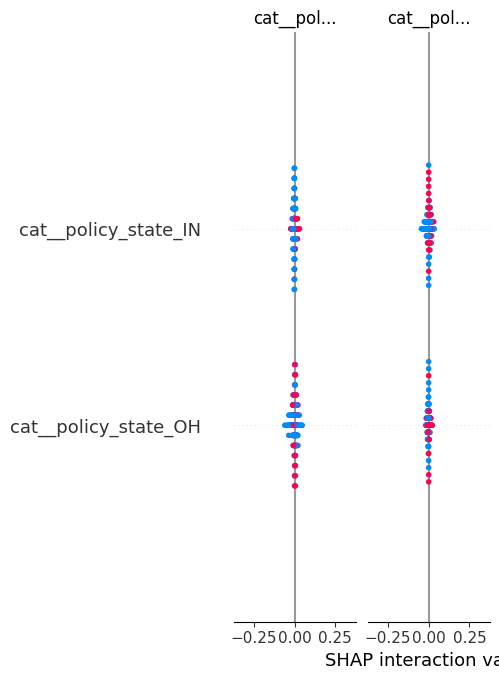

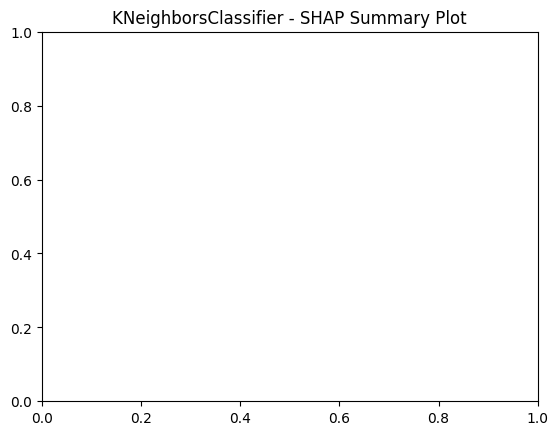

In [ ]:
if model_name == 'KNeighborsClassifier':
    explainer = shap.KernelExplainer(fitted_model.predict_proba, X_test_transformed_df)
    
    # Get SHAP values for the entire dataset
    shap_values = explainer.shap_values(X_test_transformed_df)
    
    # If `shap_values` is a list (for each class), use only one class for visualization
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Selecting the SHAP values for class 1, for example
    
    print(f"shap_values.shape: {shap_values.shape}")  # Expected shape: (200, 66)
    print(f"X_test_transformed_df.shape: {X_test_transformed_df.shape}")
    
    

In [ ]:
plt.figure(figsize=(25, 6))
print(f"shap_values.shape: {shap_values.shape}")
print(f"X_test_transformed_df.shape: {X_test_transformed_df.shape}")
#shap.summary_plot(shap_values, X_test_transformed_df, show=True)
shap.force_plot(explainer.expected_value[0], shap_values, X_test_transformed_df,show=False)
plt.title(f"{model_name} - SHAP Summary Plot")
plt.show()

shap_values.shape: (200, 66, 2)
X_test_transformed_df.shape: (200, 66)


## XGBoost

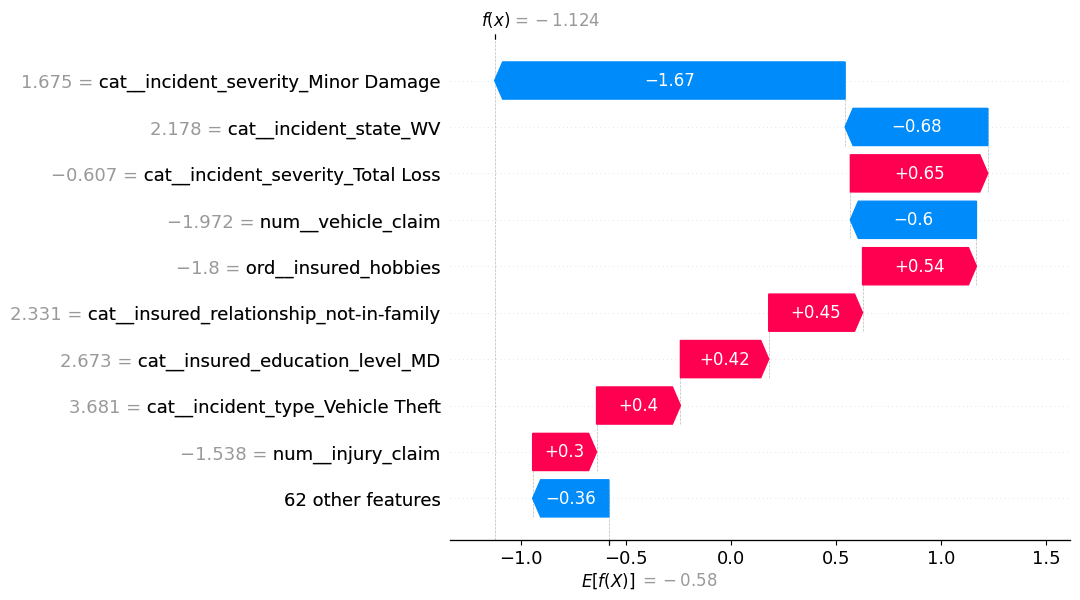

In [24]:
import shap
model_name = "XGBClassifier" # ["DecisionTreeClassifier", "RandomForestClassifier", "LogisticRegression", "XGBClassifier", 'KNeighborsClassifier']
pipeline, metrics_test = load_pipeline(model_name)
pipeline.fit(X_train, y_train)
preprocessor = copy.deepcopy(pipeline)
preprocessor.steps = [(name, step) for name, step in preprocessor.steps if name != 'model']

# Transform X_test using the preprocessor and retrieve transformed feature names
X_test_transformed = preprocessor.transform(X_test)


if isinstance(preprocessor.named_steps['column_transformer'], ColumnTransformer):
    feature_names = preprocessor.named_steps['column_transformer'].get_feature_names_out()
else:
    feature_names = X_test.columns  # Use original names if no transformation

# Confirm shape match with SHAP
if X_test_transformed.shape[1] != len(feature_names):
    raise ValueError(f"Mismatch: {X_test_transformed.shape[1]} transformed features vs {len(feature_names)} feature names.")

# Convert transformed data to DataFrame for SHAP with feature names
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)
        
fitted_model = pipeline.named_steps['model']

explainer = shap.Explainer(fitted_model, X_test_transformed_df)
shap_values = explainer(X_test_transformed_df)

shap.plots.waterfall(shap_values[0]) #worked for XGBClassifier, GradientBoostingClassifier
#shap.plots.waterfall(shap_values[0,:,0]) #worked for XGBClassifier, GradientBoostingClassifier



In [19]:
# Get shap values
def shap_values_to_list(shap_values, model):
    shap_as_list=[]
    for i in range(len(model.classes_)):
        shap_as_list.append(shap_values[:,:,i])
    return shap_as_list

In [20]:
# Create a SHAP TreeExplainer
explainer = shap.Explainer(fitted_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_transformed_df)


shap_as_list = shap_values_to_list(shap_values, fitted_model)
shap.summary_plot(shap_as_list, X_test_transformed_df, plot_type="bar")

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: XGBClassifier(alpha=5.5265379341442664e-05, base_score=None, booster='gblinear',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.20091184080798025, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.0075323413967032845,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, ...)

In [ ]:
# Setup the dataframe for the Shap values
df_shap = pd.DataFrame(shap_values, columns=X_test_transformed_df.columns)
df_shap.head(5)

In [ ]:
# For illustration, use all samples for prediction
y_pred = pipeline.predict(X_test)

df_pred = pd.DataFrame(y_pred, columns=['pred'])
df_pred.head(5)

In [ ]:
# merge the prediction and shap values
df_pred_shap = pd.concat([df_pred,df_shap], axis=1)

df_pred_shap.head(5)

In [ ]:
# Check the shape of pred and shap dataframes
print('Pred size : {}, Shap size : {}'.format(df_pred.shape, df_shap.shape))

In [ ]:
# set the true and false prediction into two differnt dataframes
df_pred_shap_1 = df_pred_shap[df_pred_shap['pred'] == 1].reset_index()
df_pred_shap_0 = df_pred_shap[df_pred_shap['pred'] == 0].reset_index()

print('True : {}, False :{}'.format(df_pred_shap_1.shape, df_pred_shap_0.shape))

In [ ]:
import random
# randomly select an index from a dataframe
def random_index_selection(dataframe):
    index_list = dataframe.index.tolist()
    random_index = random.choice(index_list)
    return random_index

In [ ]:
# randomly select 4 rows
idx = [None] * 4

for i in [0,1,2,3]:
    idx[i] = random_index_selection(df_pred_shap_1)

print(idx)

# Manually select some instances with high variance for illustration purpose
idx =[67, 52, 79, 42]

# Select the row corresponding to instance 0
instances = df_pred_shap_1.drop(['pred','index'], axis=1)


# Create a bar chart of the feature values
fig, ax = plt.subplots(2, 2, figsize=(15,10))

# Create a bar chart in the first subplot

ax[0, 0].bar(instances.iloc[idx[0],:].index.tolist(), instances.iloc[idx[0],:].values.tolist())
ax[0, 1].bar(instances.iloc[idx[1],:].index.tolist(), instances.iloc[idx[1],:].values.tolist())
ax[1, 0].bar(instances.iloc[idx[2],:].index.tolist(), instances.iloc[idx[2],:].values.tolist())
ax[1, 1].bar(instances.iloc[idx[3],:].index.tolist(), instances.iloc[idx[3],:].values.tolist())

# ax.bar(instance.index, instance.values, ax[0][0])

# # Set labels and title
# ax.set_xlabel('Feature')
# ax.set_ylabel('Value')

# Set title for the first subplot
ax[0, 0].set_title('SHAP Values of Instance ' + str(idx[0]))
ax[0, 1].set_title('SHAP Values of Instance ' + str(idx[1]))
ax[1, 0].set_title('SHAP Values of Instance ' + str(idx[2]))
ax[1, 1].set_title('SHAP Values of Instance ' + str(idx[3]))

# Rotate x-axis labels if needed
# Rotate x-axis labels if needed
ax[0, 0].tick_params(axis='x', rotation=90)
ax[0, 1].tick_params(axis='x', rotation=90)
ax[1, 0].tick_params(axis='x', rotation=90)
ax[1, 1].tick_params(axis='x', rotation=90)

# Show the plot
plt.show()

## Non Tree Based Modle - SHAP

In [ ]:
model_name = "XGBClassifier"  # GradientBoostingClassifier, XGBClassifier
pipeline, metrics_test = load_pipeline(model_name)
pipeline.fit(X_train, y_train)
preprocessor = copy.deepcopy(pipeline)
preprocessor.steps = [(name, step) for name, step in preprocessor.steps if name != 'model']
shap.initjs()
# Transform X_test using the preprocessor and retrieve transformed feature names
X_test_transformed = preprocessor.transform(X_test)


if isinstance(preprocessor.named_steps['column_transformer'], ColumnTransformer):
    feature_names = preprocessor.named_steps['column_transformer'].get_feature_names_out()
else:
    feature_names = X_test.columns  # Use original names if no transformation

# Confirm shape match with SHAP
if X_test_transformed.shape[1] != len(feature_names):
    raise ValueError(f"Mismatch: {X_test_transformed.shape[1]} transformed features vs {len(feature_names)} feature names.")



# Convert transformed data to DataFrame for SHAP with feature names
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)
        
fitted_model = pipeline.named_steps['model']


"""explainer = shap.Explainer(fitted_model, X_test_transformed_df)
shap_values = explainer(X_test_transformed_df)
# SHAP Summary plot (this part remains the same)
shap.summary_plot(shap_values, X_test_transformed_df, show=False)"""


# XGBoost
explainer = shap.Explainer(fitted_model)
shap_values = explainer.shap_values(X_test_transformed_df)

shap.plots.waterfall(shap_values[0])
#shap.summary_plot(shap_values, X_test_transformed_df, show=False)
#shap.summary_plot(shap_values, X_test_transformed_df, plot_type="bar")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def plot_feature_importance(model, feature_names=None, top_n=20):
    """
    Plot the feature importance of a fitted tree-based model.

    Parameters:
    -----------
    model : estimator
        A fitted tree-based model with `feature_importances_` attribute (e.g., RandomForest, GradientBoosting).
    
    feature_names : list or None
        List of feature names. If None, numerical indices are used as feature names.
    
    top_n : int, default=20
        The number of top features to plot. If `None`, all features will be plotted.
    """
    # Check if the model has feature_importances_ attribute
    try:
        if not hasattr(model, 'feature_importances_'):
            importance_values = model.coef_[0]
        else:
            # Get feature importance values and sort them in descending order
            importance_values = model.feature_importances_
    except:
        raise ValueError("The model does not have `feature_importances_` attribute.")

    
    
    # Create a DataFrame for better manipulation and sorting
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(len(importance_values))]
    
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_values})
    
    # Sort features by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    # If top_n is specified, select the top_n features
    if top_n is not None and top_n < len(importance_df):
        importance_df = importance_df.head(top_n)
    
    # Plot the feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df, hue='Feature', palette='viridis', dodge=False, legend=False)
    plt.title('Top Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()


In [ ]:
fitted_model = pipeline.named_steps['model']
fitted_model

In [ ]:
# Use the function to plot the feature importance
plot_feature_importance(fitted_model, feature_names=feature_names, top_n=20)

In [ ]:
import shap
import copy
shap.initjs()

In [ ]:
preprocessor = copy.deepcopy(pipeline)
preprocessor.steps = [(name, step) for name, step in preprocessor.steps if name != 'model']

# Extract the final model
final_model = pipeline.named_steps['model']

preprocessor 
    

In [ ]:
# Transform X_test using the pipeline
X_test_transformed = preprocessor.fit_transform(X_test)

In [ ]:
final_model.fit(preprocessor, y_train)
y_pred = pipeline.predict(X_test)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba) #Calculate Roc

In [ ]:
explainer = shap.Explainer(pipeline["model"], feature_names=feature_names)

In [ ]:
final_model

In [ ]:
# Transform X_test using the pipeline
X_test_transformed = preprocessor.transform(X_test)


final_model.fit(X_test_transformed, y_train)

# Compute SHAP values for the transformed X_test
explainer = shap.Explainer(final_model)
shap_values = explainer.shap_values(X_test_transformed)



# Summary Plot
shap.summary_plot(shap_values, X_test_transformed)

In [ ]:
# Assuming 'model' is the final model step in your pipeline
model = pipeline.steps[-1][1]

# Transform X_test using the pipeline
X_test_transformed = pipeline.transform(X_test)

# Compute SHAP values for the transformed X_test
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test_transformed)

# Summary Plot
shap.summary_plot(shap_values, X_test_transformed)

In [ ]:
# Transform X_test using the fitted preprocessor
X_test_transformed = preprocessor.transform(X_test)
    
# Get transformed feature names if the preprocessor is a ColumnTransformer
if feature_names is None and isinstance(preprocessor.named_steps['preprocessor'], ColumnTransformer):
    feature_names = list(preprocessor.named_steps['preprocessor'].get_feature_names_out())

# Convert transformed data to a DataFrame with feature names
X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names)

# Extract the final model
final_model = pipeline.named_steps['model']

In [ ]:
explainer = shap.Explainer(final_model)
shap_values = explainer.shap_values(X_test_transformed)

In [ ]:
shap.summary_plot(shap_values, X_test_transformed)

In [ ]:
shap.summary_plot(shap_values, X_test_transformed, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, X_test_transformed.values, feature_names = X_test_transformed.columns)

In [ ]:
# Assuming you have a multi-output model and want to explain the first output
instance = X_test_transformed.iloc[0]

# Extract SHAP values for the first instance and first output
instance_shap_values = shap_values[0, 0]

# Create Explanation object
explanation = shap.Explanation(instance_shap_values, explainer.expected_values[0], instance)

# Plot waterfall plot
shap.waterfall_plot(explanation)

In [ ]:
X_test_transformed.head()

In [ ]:
from evaluation_artefacts import log_classification_artefacts


In [ ]:
log_classification_artefacts(pipeline, X_test, y_test, feature_names, model_name)